In [1]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Implementing Ensemble Methods with Python

In this section, we will see how to implement the ensemble methods we learned in the previous section using Python. We will work with the Titanic dataset, which contains information about passengers and whether they survived. 

Earlier in the chapter, we preprocessed the data by handling missing values and encoding categorical variables. We work with the same preprocessed dataset. If you click on the following code cell shows, it will show you the pre processing we performed. 

In [2]:
# Importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset
Titanic_df = pd.read_csv("Titanic-Dataset.csv")
Titanic_df

# Drop 'Cabin' column because most of its values were missing
Titanic_df = Titanic_df.drop('Cabin', axis=1)

# Drop rows with missing values because `Age` and `Embarked` had a few missing values
Titanic_df = Titanic_df.dropna()

# Removing the Identifier Columns
Titanic_df = Titanic_df.drop(['PassengerId', 'Name', 'Ticket'], axis=1)

# Convert the string labels to numerical labels
Titanic_df['Sex_coded']=pd.Categorical(Titanic_df['Sex']).codes
Titanic_df['Embarked_coded']=pd.Categorical(Titanic_df['Embarked']).codes

# Drop 'Sex' and 'Embarked' columns 
Titanic_df = Titanic_df.drop(['Sex', 'Embarked'], axis=1)

# Rename the columns 'Sex_coded' and 'Embarked_coded' 
Titanic_df = Titanic_df.rename(columns={'Sex_coded': 'Sex', 'Embarked_coded': 'Embarked'})

Titanic_df


Survived  Pclass   Age  SibSp  Parch     Fare  Sex  Embarked
0           0       3  22.0      1      0   7.2500    1         2
1           1       1  38.0      1      0  71.2833    0         0
2           1       3  26.0      0      0   7.9250    0         2
3           1       1  35.0      1      0  53.1000    0         2
4           0       3  35.0      0      0   8.0500    1         2
..        ...     ...   ...    ...    ...      ...  ...       ...
885         0       3  39.0      0      5  29.1250    0         1
886         0       2  27.0      0      0  13.0000    1         2
887         1       1  19.0      0      0  30.0000    0         2
889         1       1  26.0      0      0  30.0000    1         0
890         0       3  32.0      0      0   7.7500    1         1

[712 rows x 8 columns]

Before building our ensemble models, we need to split the data into training and test sets. We make this split using the `train_test_split` function from scikit-learn's `model_selection` module.

In [3]:
from sklearn.model_selection import train_test_split

X = Titanic_df.drop(columns=['Survived'])
y = Titanic_df['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

The function takes our feature matrix `X` and target variable `y`, and returns four datasets: `X_train` and `y_train` for training, and `X_test` and `y_test` for testing. The `test_size=0.2` parameter allocates 20% of the data for testing. The `random_state=10` parameter ensures reproducibility by producing the same random split each time.

We will implement three ensemble methods: Bagging, Random Forests, and AdaBoost. We will train each method on the training data, evaluate their performance on the test data, and compare their results to see which performs best for predicting Titanic survival.

## Bagging

We can implement bagging in Python using scikit-learn's `BaggingClassifier`. See [here](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) for documentation.

The parameters we use in creating our bagging model are:
- **`estimator`**: The base model to use. Here, we use `DecisionTreeClassifier()` i.e. our building blocks are decision trees.
- **`n_estimators`**: The number of bootstrap training datasets and trees to create. We use 100 trees.
- **`random_state`**: Ensures we get the same results every time we run the code, making it reproducible.

In [4]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# Create a bagging classifier with decision trees as weak learners
bagging_model = BaggingClassifier(
    estimator=DecisionTreeClassifier(),
    n_estimators=100,
    random_state=42
)

In [5]:
# Train the model
bagging_model.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=100,
                  random_state=42)

Lets see how the 100 trees in our bagging ensemble vote for the first passenger in our test set. 

In [6]:
# Get predictions from all trees for the first test example
tree_predictions = [tree.predict([X_test.iloc[0].values]) for tree in bagging_model.estimators_]
votes = np.array(tree_predictions).flatten()

print(f"Trees voting 'Survived': {np.sum(votes == 1)}")
print(f"Trees voting 'Not Survived': {np.sum(votes == 0)}")

Trees voting 'Survived': 33
Trees voting 'Not Survived': 67


Since we use majority vote in classification, we would therefore predict the first passenger to not survive. 
We now make the predictions on the whole test set and evaluate the model's overall accuracy. For that, we import `accuracy_score` from `sklearn.metrics`.

In [7]:
# Make predictions
y_pred_bagging = bagging_model.predict(X_test)

from sklearn.metrics import accuracy_score

# Evaluate accuracy
bagging_accuracy = accuracy_score(y_test, y_pred_bagging)
print(f"Bagging Accuracy: {bagging_accuracy:.4f}")

Bagging Accuracy: 0.8042


This means our bagging model correctly predicts survival for approximately 80% of the passengers in the test set.

We can also visualize the feature importance for each of the features used in the modeling. Each tree calculates its own feature importance based on the bootstrap sample it was trained on. We average these importances across all trees to get a more robust estimate of which features are most important for prediction.

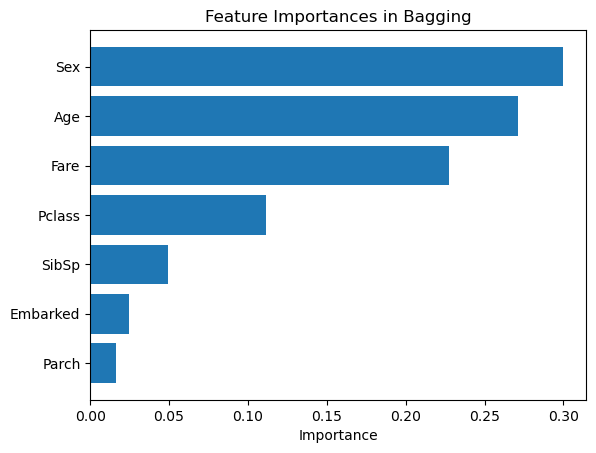

In [8]:
# Calculate average feature importance across all trees
importances = np.mean([tree.feature_importances_ for tree in bagging_model.estimators_], axis=0)

# Sort features by importance
indices = np.argsort(importances)
sorted_features = X_train.columns[indices]
sorted_importances = importances[indices]

# Plot
plt.barh(sorted_features, sorted_importances)
plt.xlabel('Importance')
plt.title('Feature Importances in Bagging')
plt.show()

From our bar chart, it looks like `Sex`, `Age`, and `Fare` played the most important role in predicting survival. Now, we do the same modeling with Random Forest and AdaBoost. 

## Random Forest

We implement Random Forests using scikit-learn's `RandomForestClassifier`. See [here](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) for documentation. 

We set the following parameters:
- **`n_estimators`**: The number of trees in the forest. We use 100 trees, same as in bagging.
- **`random_state`**: To ensures reproducibility.

By default, `RandomForestClassifier` uses $m = \sqrt{p}$ features at each split for classification, where $p$ is the total number of features. With our 7 features, $\sqrt{7} \approx 2.65$, so 2 features are randomly selected at each split.

In [9]:
from sklearn.ensemble import RandomForestClassifier

# Create a Random Forest classifier
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42
)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluate accuracy
rf_accuracy = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {rf_accuracy:.4f}")

Random Forest Accuracy: 0.8112


Our Random Forest model achieves approximately 81% accuracy, which is a slight improvement over the Bagging model (80%). This demonstrates how the additional randomness of feature selection can lead to better predictions. Lets compare the importance of the features in random forest model with bagging. 


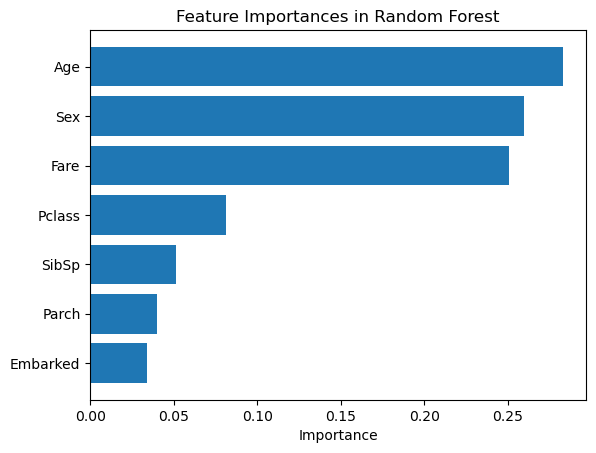

In [10]:
# Get feature importances and sort features by importance
rf_importances = rf_model.feature_importances_
indices = np.argsort(rf_importances)  
sorted_features = X_train.columns[indices]
sorted_importances = rf_importances[indices]

# Plot (barh displays bottom to top, so ascending = highest at top)
plt.barh(sorted_features, sorted_importances)
plt.xlabel('Importance')
plt.title('Feature Importances in Random Forest')
plt.show()

Similar to Bagging, `Sex`, `Age`, and `Fare` remain the most important features. However, Random Forest ranks `Age` higher than `Sex`, showing how random feature selection can shift feature importance rankings.

## AdaBoost

We implement AdaBoost using scikit-learn's `AdaBoostClassifier`. See [here](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html) for documentation.

We set the following parameters:
- **`estimator`**: The base model to use. We use `DecisionTreeClassifier(max_depth=1)` to create stumps (trees with only one split).
- **`n_estimators`**: The number of boosting iterations (stumps to create). We use 100.
- **`random_state`**: Ensures reproducibility.

In [11]:
from sklearn.ensemble import AdaBoostClassifier

# Create an AdaBoost classifier
adaboost_model = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=100,
    random_state=42
)

# Train the model
adaboost_model.fit(X_train, y_train)

# Make predictions
y_pred_adaboost = adaboost_model.predict(X_test)

# Evaluate accuracy
adaboost_accuracy = accuracy_score(y_test, y_pred_adaboost)
print(f"AdaBoost Accuracy: {adaboost_accuracy:.4f}")

AdaBoost Accuracy: 0.8252


For our dataset, AdaBoost shows the best prediction accuracy so far of 82.52%. Let us visualize the feature importance in this case. 

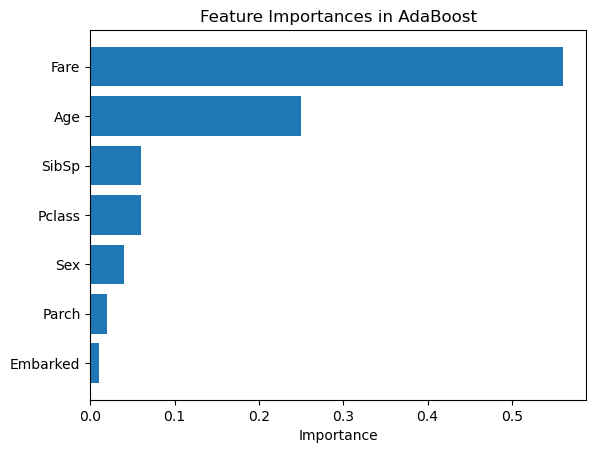

In [12]:
# Get feature importances and sort features by importance
adaboost_importances = adaboost_model.feature_importances_
indices = np.argsort(adaboost_importances)
sorted_features = X_train.columns[indices]
sorted_importances = adaboost_importances[indices]

# Plot
plt.barh(sorted_features, sorted_importances)
plt.xlabel('Importance')
plt.title('Feature Importances in AdaBoost')
plt.show()

The feature importance pattern in AdaBoost differs significantly from the other methods. `Fare` is by far the most important feature, with `Age` being moderately important followed by `SibSp`. All other features, including `Sex` which was highly important in Bagging and Random Forests, show much lower importance in AdaBoost. 

This shows an important characteristic of AdaBoost with stumps: since each stump makes only a single split, the sequential learning process can emphasize different features than methods using deeper trees. This is not an error, but rather reflects how different ensemble approaches can prioritize features differently even on the same data.

## Hyperparameter Tuning with Grid Search

So far, we have manually selected hyperparameters for our models. For example, in Random Forest, we chose `n_estimators=100` and used the default value for `max_features` (which is 'sqrt'). While these are reasonable choices, they may not be optimal. Selecting the right hyperparameters is crucial for achieving the best model performance, but manually testing different combinations can be time-consuming and inefficient.

**Grid search** is a systematic method for hyperparameter tuning that automates this process. It evaluates a predefined set of hyperparameter combinations to find the configuration that produces the best performance.

Think of grid search as exploring a grid where each axis represents a hyperparameter, and each point on the grid represents a specific combination of hyperparameter values. Grid search exhaustively tests each combination to find the best one.

Grid search involves three main components:

- **Hyperparameter Space:** The range of values to explore for each hyperparameter. For example, testing `n_estimators` values of 50, 100, and 200.
- **Scoring Metric:** The performance metric used to evaluate each combination, such as accuracy or F1-score.
- **Cross-Validation:** Recall that cross-validation splits the training data into multiple folds to evaluate performance more reliably, ensuring the results are not due to a particular split of the data.

Let us apply grid search to tune our Random Forest model. Note that Random Forest has many hyperparameters, and we have been using their default values so far. Here, we will tune four key hyperparameters:

- **`n_estimators`**: The number of trees in the forest.
- **`max_depth`**: The maximum depth of each tree. 
- **`max_features`**: The number of features to consider when looking for the best split. Recall that the default for classification is `'sqrt'`.
- **`min_samples_split`**: The minimum number of samples required to split an internal node.

Please see the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) for more hyperparameters and their default values. 

In [13]:
# Import necessary libraries
from sklearn.model_selection import GridSearchCV

# Create a Random Forest Classifier
random_forest_model = RandomForestClassifier(random_state=42)

# Define the parameter grid for grid search
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [None, 20, 30],  # Include None
    'max_features': ['sqrt', 'log2', None],
    'min_samples_split': [2, 5, 10]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(random_forest_model, param_grid, cv=10, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best parameters from grid search
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

# Get the best model 
best_random_forest_model = grid_search.best_estimator_

# Make predictions on the test data
predictions = best_random_forest_model.predict(X_test)

# Evaluate the model accuracy
accuracy = accuracy_score(y_test, predictions)
print(f"Random Forest Accuracy with Grid Search: {accuracy:.4f}")

Best Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 50}
Random Forest Accuracy with Grid Search: 0.8112


In the above grid search, we tested $4 \times 3 \times 3 \times 3 = 108$ different combinations of hyperparameter values using cross-validation. 

Grid search identified the best combination as: unlimited tree depth (`max_depth=None`), square root of features at each split (`max_features='sqrt'`), minimum of 10 samples required to split a node (`min_samples_split=10`), and 50 trees in the forest (`n_estimators=50`). This configuration achieves an accuracy of 81.12% which is the same as our original Random Forest model. However, there is an important advantage: the tuned model uses only 50 trees instead of 100, meaning it trains approximately twice as fast while maintaining the same predictive performance. This illustrates how hyperparameter tuning can find more efficient configurations without sacrificing performance.

```{raw} html
<!-- NEW_TERMS_START -->
<div style="border-left:6px solid #800000; background: rgba(255,255,255,0.06) !important; box-shadow:none !important; padding:1rem; border-radius:10px; margin:1rem 0;">
  <div style="display:flex; align-items:center; gap:.6rem; margin-bottom:.6rem;">
    <span style="display:inline-block; font-weight:700; padding:.25rem .6rem; border:1px solid #800000; border-radius:.5rem; background:rgba(128,0,0,.25); color:inherit;">
      New in This Chapter
    </span>
  </div>

  <div style="display:grid; grid-template-columns:repeat(auto-fit,minmax(240px,1fr)); gap:1.25rem; align-items:start;">
    
        <div>
          <h4 style="margin:.25rem 0 .4rem; font-size:1rem; font-weight:700;">
            <span style="border-bottom:2px solid rgba(128,0,0,.55); padding-bottom:2px;">Terms</span>
          </h4>
          <ul style="margin:0; padding-left:1.2rem;">
            <li><a href="../../glossary.html#adaboost" style="color:inherit; text-decoration:underline;">AdaBoost</a></li><li><a href="../../glossary.html#bagging" style="color:inherit; text-decoration:underline;">Bagging</a></li><li><a href="../../glossary.html#boosting" style="color:inherit; text-decoration:underline;">Boosting</a></li><li><a href="../../glossary.html#branches" style="color:inherit; text-decoration:underline;">Branches</a></li><li><a href="../../glossary.html#decision-tree" style="color:inherit; text-decoration:underline;">Decision Tree</a></li><li><a href="../../glossary.html#ensemble-methods" style="color:inherit; text-decoration:underline;">Ensemble Methods</a></li><li><a href="../../glossary.html#gini-impurity" style="color:inherit; text-decoration:underline;">Gini impurity</a></li><li><a href="../../glossary.html#gradient-boosting" style="color:inherit; text-decoration:underline;">Gradient Boosting</a></li><li><a href="../../glossary.html#internal-nodes" style="color:inherit; text-decoration:underline;">Internal Nodes</a></li><li><a href="../../glossary.html#leaf-nodes-or-leaves" style="color:inherit; text-decoration:underline;">Leaf Nodes or Leaves</a></li><li><a href="../../glossary.html#post-pruning" style="color:inherit; text-decoration:underline;">Post-pruning</a></li><li><a href="../../glossary.html#pre-pruning" style="color:inherit; text-decoration:underline;">Pre-pruning</a></li><li><a href="../../glossary.html#pure-leaf" style="color:inherit; text-decoration:underline;">Pure Leaf</a></li><li><a href="../../glossary.html#random-forest" style="color:inherit; text-decoration:underline;">Random Forest</a></li><li><a href="../../glossary.html#recursive-binary-splitting" style="color:inherit; text-decoration:underline;">Recursive Binary Splitting</a></li><li><a href="../../glossary.html#residual-sum-of-squares" style="color:inherit; text-decoration:underline;">Residual Sum of Squares</a></li><li><a href="../../glossary.html#root-node" style="color:inherit; text-decoration:underline;">Root Node</a></li><li><a href="../../glossary.html#stump" style="color:inherit; text-decoration:underline;">Stump</a></li><li><a href="../../glossary.html#tree-pruning" style="color:inherit; text-decoration:underline;">Tree Pruning</a></li><li><a href="../../glossary.html#tree-based-methods" style="color:inherit; text-decoration:underline;">Tree-based Methods</a></li><li><a href="../../glossary.html#weak-learners" style="color:inherit; text-decoration:underline;">Weak Learners</a></li>
          </ul>
        </div>
        
        <div>
          <h4 style="margin:.25rem 0 .4rem; font-size:1rem; font-weight:700;">
            <span style="border-bottom:2px solid rgba(128,0,0,.55); padding-bottom:2px;">Code</span>
          </h4>
          <ul style="margin:0; padding-left:1.2rem;">
            <li><a href="../../code-glossary.html#adaboostclassifier" style="color:inherit; text-decoration:underline;">AdaBoostClassifier</a></li><li><a href="../../code-glossary.html#baggingclassifier" style="color:inherit; text-decoration:underline;">BaggingClassifier</a></li><li><a href="../../code-glossary.html#decisiontreeclassifier" style="color:inherit; text-decoration:underline;">DecisionTreeClassifier</a></li><li><a href="../../code-glossary.html#gridsearchcv" style="color:inherit; text-decoration:underline;">GridSearchCV</a></li><li><a href="../../code-glossary.html#modelestimators" style="color:inherit; text-decoration:underline;">model.estimators_</a></li><li><a href="../../code-glossary.html#modelfeature-importances" style="color:inherit; text-decoration:underline;">model.feature_importances_</a></li><li><a href="../../code-glossary.html#pdcategoricalvaluescodes" style="color:inherit; text-decoration:underline;">pd.Categorical(values).codes</a></li><li><a href="../../code-glossary.html#plot-tree" style="color:inherit; text-decoration:underline;">plot_tree</a></li><li><a href="../../code-glossary.html#randomforestclassifier" style="color:inherit; text-decoration:underline;">RandomForestClassifier</a></li>
          </ul>
        </div>
        
  </div>
</div>
<!-- NEW_TERMS_END -->
```
